# Consigna del desafío 3

Utilizar otro dataset y poner en práctica la predicción de próxima palabra

## Importamos librerias

In [2]:
!pip install -q gradio


In [3]:
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding
from sklearn.model_selection import train_test_split
from scipy.special import softmax

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Importamos el dataset

In [4]:
# Descargar la carpeta de dataset

if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2025-09-28 22:12:12--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2025-09-28 22:12:12--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2025-09-28 22:12:12--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

## Preparamos los datos de entrada

In [5]:
df = pd.read_csv('songs_dataset/eminem.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-3844847657.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/eminem.txt', sep='/n', header=None)


,0
0,"Look, I was gonna go easy on you and not to hu..."
1,But I'm only going to get this one chance
2,"Something's wrong, I can feel it (Six minutes,..."
3,"Just a feeling I've got, like something's abou..."
4,"If that means, what I think it means, we're in..."


In [6]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 6812


### Tokenizamos y vemos la cantidad de palabras empleadas en cada estrofa de nuestra cancion

In [7]:
segmented_sentences = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras
for _, row in df[:None].iterrows():
    segmented_sentences.append(text_to_word_sequence(row[0]))

In [8]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([1.550e+02, 5.170e+02, 4.310e+02, 1.140e+03, 7.130e+02, 1.375e+03,
        1.140e+03, 3.530e+02, 4.560e+02, 1.000e+02, 1.820e+02, 1.040e+02,
        5.200e+01, 4.800e+01, 2.000e+01, 1.900e+01, 4.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00]),
 array([ 1. ,  2.6,  4.2,  5.8,  7.4,  9. , 10.6, 12.2, 13.8, 15.4, 17. ,
        18.6, 20.2, 21.8, 23.4, 25. , 26.6, 28.2, 29.8, 31.4, 33. ]),
 <BarContainer object of 20 artists>)

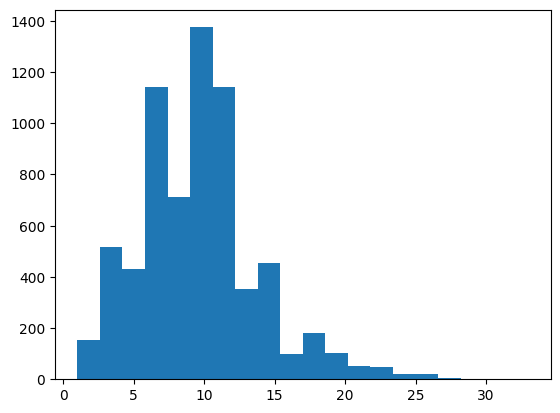

In [9]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [10]:
max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
print(f'max_context_size: {max_context_size}')

max_context_size: 10


In [11]:

tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

### Dividimos entre dataset de train y validacion

In [12]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)


### Ajustamos los datos de entrenamiento al maximo de pabras del contexto

In [13]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

In [14]:
len(tok_sent)

11023

In [15]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [16]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [17]:

train_seqs.shape

(96401, 11)

In [18]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [19]:

# Palabras del vocabulario
tok.index_word


{1: 'i',
 2: 'the',
 3: 'you',
 4: 'to',
 5: 'a',
 6: 'and',
 7: 'my',
 8: "i'm",
 9: 'it',
 10: 'me',
 11: 'in',
 12: 'that',
 13: 'like',
 14: 'of',
 15: 'this',
 16: 'but',
 17: 'just',
 18: 'so',
 19: 'on',
 20: 'is',
 21: 'your',
 22: "don't",
 23: 'up',
 24: 'with',
 25: 'get',
 26: 'for',
 27: 'be',
 28: "it's",
 29: 'no',
 30: 'all',
 31: 'know',
 32: 'what',
 33: 'now',
 34: 'out',
 35: 'when',
 36: 'they',
 37: 'was',
 38: 'not',
 39: 'fuck',
 40: "ain't",
 41: 'got',
 42: 'go',
 43: 'at',
 44: 'can',
 45: 'back',
 46: 'if',
 47: 'shit',
 48: 'we',
 49: 'he',
 50: 'do',
 51: 'one',
 52: 'from',
 53: "'cause",
 54: 'as',
 55: 'never',
 56: 'see',
 57: 'think',
 58: 'say',
 59: 'his',
 60: 'make',
 61: "you're",
 62: 'off',
 63: 'oh',
 64: "that's",
 65: 'way',
 66: 'down',
 67: 'who',
 68: 'her',
 69: 'have',
 70: "can't",
 71: 'take',
 72: 'right',
 73: 'ass',
 74: 'bitch',
 75: 'too',
 76: 'or',
 77: 'name',
 78: 'let',
 79: 'want',
 80: 'love',
 81: 'then',
 82: 'are',
 83:

In [20]:

# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

6114

In [21]:

# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'i': 1, 'the': 2, 'you': 3, 'to': 4, 'a': 5, 'and': 6, 'my': 7, "i'm": 8, 'it': 9, 'me': 10, 'in': 11, 'that': 12, 'like': 13, 'of': 14, 'this': 15, 'but': 16, 'just': 17, 'so': 18, 'on': 19, 'is': 20, 'your': 21, "don't": 22, 'up': 23, 'with': 24, 'get': 25, 'for': 26, 'be': 27, "it's": 28, 'no': 29, 'all': 30, 'know': 31, 'what': 32, 'now': 33, 'out': 34, 'when': 35, 'they': 36, 'was': 37, 'not': 38, 'fuck': 39, "ain't": 40, 'got': 41, 'go': 42, 'at': 43, 'can': 44, 'back': 45, 'if': 46, 'shit': 47, 'we': 48, 'he': 49, 'do': 50, 'one': 51, 'from': 52, "'cause": 53, 'as': 54, 'never': 55, 'see': 56, 'think': 57, 'say': 58, 'his': 59, 'make': 60, "you're": 61, 'off': 62, 'oh': 63, "that's": 64, 'way': 65, 'down': 66, 'who': 67, 'her': 68, 'have': 69, "can't": 70, 'take': 71, 'right': 72, 'ass': 73, 'bitch': 74, 'too': 75, 'or': 76, 'name': 77, 'let': 78, 'want': 79, 'love': 80, 'then': 81, 'are': 82, "i'll": 83, 'these': 84, 'time': 85, 'am': 86, 'how': 87, 'been': 88, 'shady': 89, "'

### Ajustamos los datos de validacion al contexto

In [22]:
# Process the validation data similarly to the training data
tok_sent_val = []

for sent in tokenized_sentences_val:
  if len(sent) > (max_context_size + 1):
    extra = len(sent) - (max_context_size + 1) + 1
    for i in range(extra):
      tok_sent_val.append(sent[i:i + max_context_size + 1])
  else:
    tok_sent_val.append(sent)

tok_sent_augm_val = []

for sent in tok_sent_val:
  subseq = [sent[:i + 2] for i in range(len(sent) - 1)]
  tok_sent_augm_val.append(pad_sequences(subseq, maxlen=max_context_size + 1, padding='pre'))

# Concatenate validation sequences
val_seqs = np.concatenate(tok_sent_augm_val, axis=0)

# Separate features and targets for validation data
X_val = val_seqs[:,:-1]
y_val = val_seqs[:,-1]

## Definicion del modelo

In [23]:
model = Sequential()

# Embedding:
# input_seq_len = 10 --> ingreso 10 palabras
# input_dim = vocab_size --> 6114 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 5)          │        30,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6115)           │       201,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,394 (1.09 MB)

 Trainable params: 285,394 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])
        self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

        self.info.append((count,count+len_seq))
        count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')


## Entrenamos el modelo

In [27]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X, y, epochs=50, callbacks=[PplCallback(tokenized_sentences_val)], validation_data=(X_val, y_val), batch_size=64)

Epoch 1/50
1501/1507 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0733 - loss: 5.3339
 mean perplexity: 28276750.0 

1507/1507 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.0733 - loss: 5.3338 - val_accuracy: 0.0695 - val_loss: 6.2122
Epoch 2/50
1506/1507 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0864 - loss: 5.1845
 mean perplexity: 43569232.0 

1507/1507 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.0864 - loss: 5.1844 - val_accuracy: 0.0773 - val_loss: 6.2142
Epoch 3/50
1503/1507 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0983 - loss: 5.0553
 mean perplexity: 133973712.0 

1507/1507 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.0983 - loss: 5.0553 - val_accuracy: 0.0828 - val_loss: 6.2700
Epoch 4/50
1502/1507 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1084 - loss: 4.9490
 mean perplexity: 1062366080.0 

1507/1507 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1084 - loss: 4.9489 - val_accuracy: 0.0896 - val_loss: 6.3299
Epoch 5/50
1504/1507 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2735858065.py:49: RuntimeWarning: divide by zero encountered in log
  scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))


1506/1507 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1695 - loss: 4.2808
 mean perplexity: inf 

1507/1507 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1695 - loss: 4.2809 - val_accuracy: 0.1157 - val_loss: 7.2383
Epoch 13/50
1504/1507 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1769 - loss: 4.2408
 mean perplexity: inf 

1507/1507 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.1769 - loss: 4.2408 - val_accuracy: 0.1156 - val_loss: 7.4248
Epoch 14/50
1503/1507 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1814 - loss: 4.1841
 mean perplexity: inf 

1507/1507 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1814 - loss: 4.1842 - val_accuracy: 0.1198 - val_loss: 7.5317
Epoch 15/50
1503/1507 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1867 - loss: 4.1587
 mean perplexity: inf 

1507/1507 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.1868 - loss: 4.1588 - val_accuracy: 0.1196 - val_loss: 7.6649
Epoch 16/50
1504/1507 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1949 - 

## Graficamos las metricas

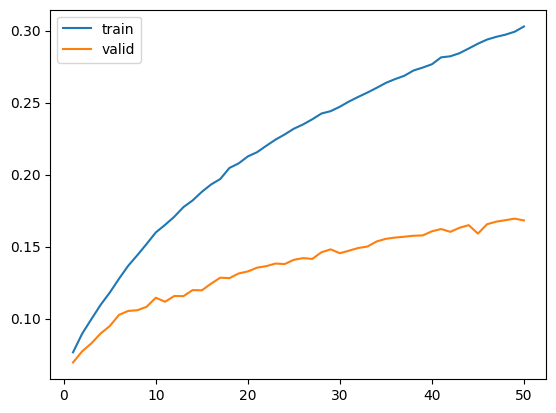

In [28]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

## Prueba interactiva

In [29]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://cdcb795875e29fabce.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://cdcb795875e29fabce.gradio.live


## Probamos generar una estrofa de 10 palabras

In [30]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text


In [31]:
input_text='i´m god'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'i´m god is a'

In [32]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [33]:
# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [34]:
# predicción con beam search
salidas = beam_search(model,num_beams=20,num_words=6,input="when i find myself in times")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

In [35]:
# veamos las salidas
decode(salidas[0])

['when i find myself in times shake that ass for me john']

## Conclusion

El modelo logró aprender algunos patrones básicos del corpus de canciones, alcanzando cerca de un 30% de precisión en el entrenamiento, pero en la validación su desempeño fue mucho más bajo (alrededor de un 17%), lo que muestra que le cuesta generalizar y predecir bien en ejemplos nuevos. Esto se explica en parte porque, aunque el corpus cuenta con 6812 documentos, el vocabulario es muy amplio (más de 6114 palabras diferentes), lo que hace que el modelo disponga de pocos ejemplos representativos por palabra y le resulte difícil capturar sus usos en distintos contextos. En conclusión, el modelo muestra un inicio prometedor, pero todavía necesita ajustes y más datos para poder predecir con mayor precisión la próxima palabra.